In [2]:
import pandas as pd
import numpy as np
import torch
import pickle
import os
from gurobipy import Model, GRB, quicksum
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch
import joblib
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = 'C:/Users/shrey/Downloads/EV Charging Station Dynamic Pricing-20250701T181708Z-1-001/EV Charging Station Dynamic Pricing/data/urban_ev_combined.csv'
DATA_DIR = 'C:/Users/shrey/Downloads/EV Charging Station Dynamic Pricing-20250701T181708Z-1-001/EV Charging Station Dynamic Pricing/data/'

MODEL_DIR = 'C:/Users/shrey/Downloads/EV Charging Station Dynamic Pricing-20250701T181708Z-1-001/EV Charging Station Dynamic Pricing/models/'
TARGET = 'volume'
# Only using the selected features based on the importance
features = [
    'is_peak', 'duration', 'duration_24h_mean',
    'charge_count', 'occupancy', 'e_price', 's_price', 'hour', 'area', 'power_kw'
]

P_MIN = 0.3 # min(e_price)=0.24 and min(s_price) = 0 however not setting it to 0 as it is not feasible for free charging station
P_MAX = 1.45 # max(e_price) = 1.8 and max(s_price) = 1.45

import csv

output_file = "C:/Users/shrey/Downloads/EV Charging Station Dynamic Pricing-20250701T181708Z-1-001/EV Charging Station Dynamic Pricing/optimized_zonewise_hourly_results.csv"
fieldnames = [
    'zone_id', 'time', 'predicted_volume',
    'static_price', 'optimal_price',
    'static_revenue', 'optimal_revenue'
]

write_header = not os.path.exists(output_file)
csv_file = open(output_file, mode='a', newline='')
writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

if write_header:
    writer.writeheader()

In [4]:
df = pd.read_csv(DATA_PATH, parse_dates=['time'])
df['zone_id'] = df['zone_id'].astype(str)

EPS = 1e-6
df['power_kw'] = df['volume'] / (df['duration'] + EPS)
df['power_kw'] = df['power_kw'].replace([np.inf, -np.inf], np.nan).fillna(0)

s_price_df = pd.read_csv(DATA_DIR+'s_price.csv')
s_price_df.rename(columns={s_price_df.columns[0]: 'time'}, inplace=True)
s_price_df['time'] = pd.to_datetime(s_price_df['time'])
s_price_df.set_index('time', inplace=True)
s_price_df.columns = s_price_df.columns.astype(str)

all_preds = []
all_prices = []
skipped_zones = []

In [5]:
zone_ids = df['zone_id'].unique()

# The hourly elasticity data is just estimate based on research papers although we need to calculate them by conducting actual study but since we have static prices data so this cannot be done

hourly_epsilons = {
    0:  0.15, 1: 0.25, 2: 0.25, 3: 0.3, 4: 0.35,
    5:  0.4, 6: 0.5, 7: 0.7, 8: 0.8, 9: 0.9,
    10: 0.8, 11: 0.7, 12: 0.6, 13: 0.7, 14: 0.75,
    15: 0.8, 16: 0.85, 17: 1.0, 18: 1.1, 19: 1.0,
    20: 0.9, 21: 0.8, 22: 0.5, 23: 0.3
}
def optimize_model(d_hat, s_prices, times):
    m = Model(env=env, name="dynamic_pricing")
    m.setParam('OutputFlag', 0)

    T = len(d_hat)
    p = m.addVars(T, lb=P_MIN, ub=P_MAX, name="p")
    x = m.addVars(T, name="x")
    y = m.addVars(T, name="exp_approx")
    adjusted_demand = m.addVars(T, name="adjusted_demand")


    P_base = sum(s_prices)/len(s_prices)
    lambda_price_penalty = 1.0 # to discourage very high prices

    x_min = min((P_MIN - s_price) / s_price if s_price > 0 else -1 for s_price in s_prices)
    x_max = max((P_MAX - s_price) / s_price if s_price > 0 else 1 for s_price in s_prices)

    x_range = max(abs(x_min), abs(x_max))
    x_vals = np.linspace(-x_range, x_range, num=15).tolist()


    for t in range(T):
        s_base = s_prices[t] if s_prices[t] > 0 else 0.3
        m.addConstr(x[t] == (p[t] - s_base) / s_base)
        hour = times[t].hour
        epsilon = abs(hourly_epsilons.get(hour, 0.76))
        y_vals = [np.exp(-epsilon * x_i) for x_i in x_vals]
        m.addGenConstrPWL(x[t], y[t], x_vals, y_vals, name=f"exp_pwl_{t}") # PWL approximation as the function is non-linear
        m.addConstr(adjusted_demand[t] == d_hat[t] * y[t])



    revenue_objective = quicksum(p[t] * adjusted_demand[t] for t in range(T))
    penalty_objective = lambda_price_penalty*quicksum((p[t] - s_prices[t])**2 for t in range(T))

    m.setObjective(revenue_objective - penalty_objective, GRB.MAXIMIZE)
    m.optimize()

    p_opt = [p[t].X for t in range(T)]

    opt_revenue = sum(
        p_opt[t] * d_hat[t] * np.exp(
            -abs(hourly_epsilons.get(times[t].hour, 0.5)) *
            ((p_opt[t] - s_prices[t]) / s_prices[t] if s_prices[t] else 0)
        )
        for t in range(T)
    )
    static_revenue = sum(s_prices[t] * d_hat[t] for t in range(T))

    return p_opt, opt_revenue, static_revenue

In [6]:
HIDDEN_SIZE = 128
SEQ_LEN = 72
class LSTM_Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=HIDDEN_SIZE, num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

In [7]:
with open(os.path.join(MODEL_DIR, 'global_volume_scaler.pkl'), 'rb') as f:
    global_volume_scaler = pickle.load(f)

for zone_id in tqdm(zone_ids):
    try:
        df_zone = df[df['zone_id'] == zone_id].copy()

        df_zone = df_zone.sort_values(by=['time'])

        model_path = os.path.join(MODEL_DIR, f'zone_{zone_id}_model.pkl')
        scaler_path = os.path.join(MODEL_DIR, f'zone_{zone_id}_scalers.pkl')
        features_path = os.path.join(MODEL_DIR, f'zone_{zone_id}_features.pkl')

        if not os.path.exists(model_path) or not os.path.exists(scaler_path) or not os.path.exists(features_path):
            print(f'Skipping {zone_id}: missing parameters')
            skipped_zones.append(zone_id)
            continue

        # Load model, scalers, and features
        model = joblib.load(model_path)
        input_size = model.lstm.input_size
        model.lstm.flatten_parameters()

        with open(scaler_path, 'rb') as f:
            scalers = pickle.load(f)
        with open(features_path, 'rb') as f:
            zone_features = pickle.load(f)

        zone_id_str = str(zone_id)


        # Ensure features exist in dataframe and scale
        for col in zone_features:
            if col not in df_zone.columns:
                print(f"Zone {zone_id}: missing feature {col} in dataframe")
                raise ValueError(f"Missing feature {col}")
            df_zone[col] = scalers[col].transform(df_zone[col].values.reshape(-1, 1)).flatten()

        # Prepare sequences
        X_seq, times, s_prices = [], [], []
        for i in range(SEQ_LEN, len(df_zone)):
            seq = df_zone.iloc[i - SEQ_LEN:i][zone_features].values.astype(np.float32)
            if seq.shape[1] != input_size:
                continue
            X_seq.append(seq)
            times.append(df_zone.iloc[i]['time'])
            try:
                s_price = s_price_df.loc[df_zone.iloc[i]['time'], zone_id_str]
            except KeyError:
                s_price = 0.0
            s_prices.append(float(s_price))

        if not X_seq:
            continue

        X_tensor = torch.tensor(np.stack(X_seq))
        X_tensor = X_tensor.to(next(model.parameters()).device)

        with torch.no_grad():
            preds = model(X_tensor).squeeze().cpu().numpy()

        log_preds = global_volume_scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
        preds = np.expm1(log_preds)
        preds = np.clip(preds, 0.1, None)

        p_opt, opt_rev, static_rev = optimize_model(preds, s_prices, times)

        for t, ts in enumerate(times):
            writer.writerow({
              'zone_id': zone_id,
              'time': ts,
              'predicted_volume': preds[t],
              'static_price': s_prices[t],
              'optimal_price': p_opt[t],
              'static_revenue': s_prices[t] * preds[t],
              'optimal_revenue': p_opt[t] * preds[t],
          })

    except Exception as e:
        print(f'Failed to optimize {zone_id}: {e}')


 78%|███████▊  | 214/275 [1:27:51<20:55, 20.58s/it]

Failed to optimize 771: some x or y values are too big (>= 1e+30)


100%|██████████| 275/275 [1:50:13<00:00, 24.05s/it]


In [8]:
results = pd.read_csv('C:/Users/shrey/Downloads/EV Charging Station Dynamic Pricing-20250701T181708Z-1-001/EV Charging Station Dynamic Pricing/optimized_zonewise_hourly_results.csv')
results['time'] = pd.to_datetime(results['time'])
results['hour'] = results['time'].dt.hour
summary = results.groupby('zone_id')[['static_revenue', 'optimal_revenue']].sum().reset_index()
summary['gain_%'] = 100 * (summary['optimal_revenue'] - summary['static_revenue']) / summary['static_revenue']

results.to_csv('C:/Users/shrey/Downloads/EV Charging Station Dynamic Pricing-20250701T181708Z-1-001/EV Charging Station Dynamic Pricing/pricing_results_by_hour.csv', index=False)
summary.to_csv('C:/Users/shrey/Downloads/EV Charging Station Dynamic Pricing-20250701T181708Z-1-001/EV Charging Station Dynamic Pricing/zonewise_revenue_comparison.csv', index=False)


**Results Obtained**

In [9]:
import seaborn as sns

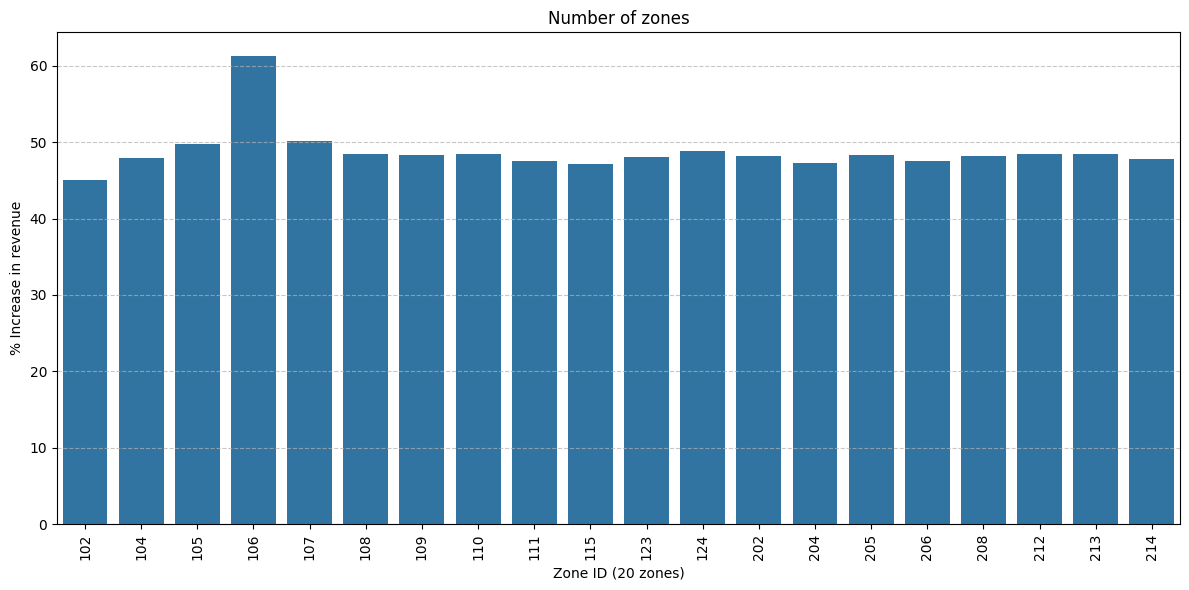

In [17]:
df = pd.read_csv('C:/Users/shrey/Downloads/EV Charging Station Dynamic Pricing-20250701T181708Z-1-001/EV Charging Station Dynamic Pricing/zonewise_revenue_comparison.csv')
df.sort_values(by=['zone_id'], inplace=True)
df_sub = df.head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x='zone_id', y='gain_%', data=df_sub)
plt.title('Number of zones')
plt.ylabel('% Increase in revenue')
plt.xlabel('Zone ID (20 zones)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [21]:
df['gain_%'] = pd.to_numeric(df['gain_%'], errors='coerce')
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['gain_%'])


mean_gain = df['gain_%'].mean()
std_gain = df['gain_%'].std()
max_gain = df['gain_%'].max()
min_gain = df['gain_%'].min()

print(f'Mean gain: {mean_gain}')
print(f'Standard deviation: {std_gain}')
print(f'Max gain: {max_gain}')
print(f'Min gain: {min_gain}')

Mean gain: 51.13341290668615
Standard deviation: 11.652244691374733
Max gain: 129.16557880527324
Min gain: 21.64635042660337
